# LIME to Inspect Image & Text Classification 

This tutorial focuses on showing how to use Local Interpretable Model-agnostic Explanations (LIME) to understand neural models. It is divided into two independent sections for the image and text classification tasks respectively. 

In [1]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json

## 1. Image Classification

In this section, we will learn applying Lime to analyze a Resnet trained on ImageNet-1k. For testing data, we use samples from PASCAL VOC 2012 since its segmentation masks can directly serve as semantic "super-pixels" for images. 

In [2]:
from torchvision.models import resnet18
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from captum.attr._core.lime import get_exp_kernel_similarity_function

from PIL import Image
import matplotlib.pyplot as plt

### 1.1 Load the model and dataset

We can directly load the pretrained Resnet from torchvision and set it to evaluation mode as our target image classifier to inspect. 

In [3]:
resnet = resnet18(pretrained=True)
resnet = resnet.eval()

This model predicts ImageNet-1k labels for given sample images. To better present the results, we also load the mapping of label index and text.

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2021-06-11 22:02:18--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving fwdproxy (fwdproxy)... 2401:db00:21ff:ff2f:face:b00c:0:1e10
Connecting to fwdproxy (fwdproxy)|2401:db00:21ff:ff2f:face:b00c:0:1e10|:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/aoboyang/.torch/models/imagenet_class_index.json.16’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2021-06-11 22:02:18 (2.11 MB/s) - ‘/home/aoboyang/.torch/models/imagenet_class_index.json.16’ saved [35363/35363]



In [5]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = {idx: label for idx, [_, label] in json.load(json_data).items()}

As mentioned before, we will use PASCAL VOC 2012 as the test data, which is available in torchvision as well. 

In [6]:
root = "./VOC"
voc_ds = VOCSegmentation(
    root,
    year='2012',
    image_set='train',
    download=False,
    transform=None,
    target_transform=None
)


This dataset provides an addional segmentation mask along with every image. Compared with inspecting each pixel, the segments (or "super-pixels") are semantically more intuitive for human to perceive. We will discuss more in section 3.

Let's pick one example to see how the image and corresponding mask look like. Here we choose an image with more than one segments besides background so that we can compare each segment's impact on the classification.

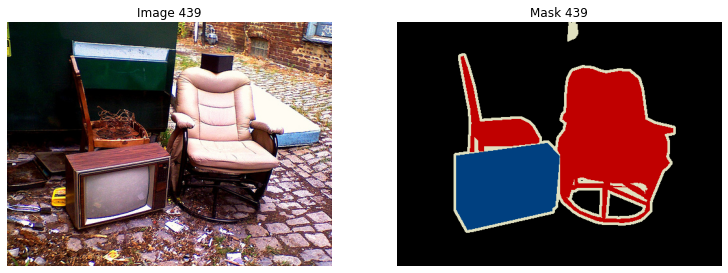

In [7]:
sample_idx = 439

def show_image(ind): 
    fig, ax = plt.subplots(1, 2, figsize=[6.4 * 2, 4.8])
    for i, (name, source) in enumerate(zip(['Image', 'Mask'], [voc_ds.images, voc_ds.masks])):
        img = Image.open(source[ind])
        ax[i].imshow(img);
        ax[i].set_title(f"{name} {ind}")
        ax[i].axis('off')

show_image(sample_idx)

### 1.2 Baseline classification

In the section, we will define our classification function which takes in an image and returns the prediction probabilities. 

The original Resnet only gives the logits of labels, so we will add a softmax layer to normalize them into probabilities. 

In [8]:
# uses torchvision transforms to convert a PIL image to a tensor and normalize it
img_to_input = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )    
])

def classify(img, print_result=True):
    output = resnet(img_to_input(img).unsqueeze(0))
    return F.softmax(output, dim=1).squeeze(0)

Then let us test it on the above sample image. We present the top 5 predicted labels to verify the result.

In [9]:
img, seg_mask = Image.open(voc_ds.images[sample_idx]), Image.open(voc_ds.masks[sample_idx])

def print_result(probs, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = idx_to_labels[str(idx)]
        print(f'{label} ({idx}):', round(prob, 4))
        
output_probs = classify(img)
print_result(output_probs, topk=5)

television (851): 0.083
screen (782): 0.0741
monitor (664): 0.0619
laptop (620): 0.0421
ashcan (412): 0.03


As we can see, the result is pretty reasonable.

## 1.3 Inspect the model prediction with Lime

In this section, we will bring in LIME from Captum to analyze how the Resnet made above prediction based on the sample image.

Like many other Captum algorithms, Lime also support analyzing a number of input features together as a group. This is very useful when dealing with images, where each color channel in each pixel is an input feature. Such group is also refered as "super-pixel". To define our desired groups over input features, all we need is to provide a feature mask.

In case of an image input, the feature mask is a 2D image of the same size, where each pixel in the mask indicates the feature group it belongs to via an integer value. Pixels of the same value define a group.

This means we can readily use POV's segmentation masks as feature masks for Captum! However, while segmentaion numbers range from 0 to 255, Captum prefers consecutive group ids for efficiency. Therefore, we will also include extra steps to convert mask IDs.

In [10]:
# convert the segmentation mask to a tensor of shape (batch, channels, height, width)
feature_mask = torch.tensor(seg_mask.getdata()).reshape(1, 1, seg_mask.size[1], seg_mask.size[0])
seg_ids = sorted(feature_mask.unique().tolist())
print('Segmentation IDs:', seg_ids)

for i, seg_id in enumerate(seg_ids):
    feature_mask[feature_mask == seg_id] = i
    
print('Feature mask IDs:', feature_mask.unique().tolist())

Segmentation IDs: [0, 9, 20, 255]
Feature mask IDs: [0, 1, 2, 3]


It is time to configure our Lime algorithm now. Essentially, Lime trains an interpretable surrogate model to simulate the target model's predictions. So, building an appropriate interpretable model is the most critical step in Lime. Fortunately, Captum has provided many most common interpretable models to save the efforts. We will demonstrate the usages of Linear Regression and Linear Lasso. Another important factor is the similarity function. Because Lime aims to explain the local behavior of an example, it will reweight the training samples according to their similarity distances. By default, Captum's Lime uses the exponential kernel on top of the consine distance. We will change to euclidean distance instead which is more popular in vision. 

In [11]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    resnet, 
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

Next, we will analyze these groups' influence on the most confident prediction `television`. Everytime we call Lime's `attribute` function, an interpretable model is trained around the given input, so unlike many other Captum's attribution algorithms, it is strongly recommended to only provide a single example as input (tensors with first dimension or batch size = 1). There are advanced use cases of passing batched inputs. Interested readers can check the [document](https://captum.ai/api/lime.html) for details.

In order to train the interpretable model, we need to specify enough training data through the argument `n_samples`. Lime creates the pertubed samples in the form of interpretable representation, i.e., a binary vector indicating the “presence” or “absence” of features. Lime needs to keep calling the target model to get the labels/values for all pertubed samples. This process can be quite time-consuming depending on the complexity of the target model and the number of samples. Setting the `perturbations_per_eval` can parallel the sampling to shorten the process as long as your machine still has capaciity. You may also consider turning on the flag `show_progress` to display a progess bar showing how many forward calls are left.

In [12]:
# add & remove dummy batch dimension before & after attribution
attrs = lr_lime.attribute(
    img_to_input(img).unsqueeze(0),
    target=output_probs.argmax().unsqueeze(0),
    feature_mask=feature_mask,
    n_samples=40,
    perturbations_per_eval=16,
    show_progress=True,
    return_input_shape=True,
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime attribution: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Attribution range: -0.4283994436264038 to 2.890220880508423


Now, let us use Captum's visualization tool to view the attribution heat map.

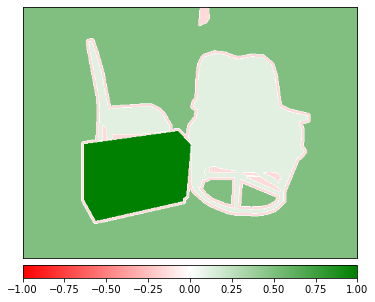

In [13]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method="heat_map",
        sign="all",
        show_colorbar=True
    )
    
show_attr(attrs)

The result looks decent: the television segment does demonstrate strongest positive correlation with the prediction, while the chairs has relatively trivial impact and the border slightly shows negative contribution.

However, we can further improve this result. One desired characteristic of interpretability is the ease for human to comprehend. We should help reduce the noisy interference and emphisze the real influential features. In our case, all features more or less show some influences. Lasso regularization can effectively help us filter them. Therefore, let us try Linear Lasso with a fit coefficient `alpha`. For all build-in sklearn wrapper model, you can directly pass any sklearn supported arguments.

Moreover, since our example only has 4 segments, there are only 16 possible combinations of interpretable representations in total. So we can exhaust each of them exactly once instead randomly sampling them. The `Lime` class's argument `perturb_func` allows us to pass a generator yielding samples. We will set it as an interator of the combinations and the `n_samples` exactly to its length.

Lime attribution: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Attribution range: -0.047024477273225784 to 2.532824993133545


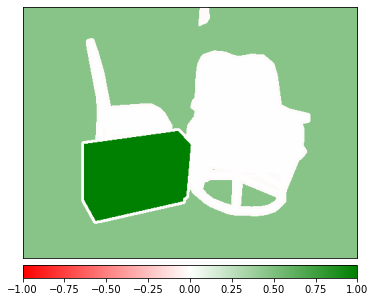

In [14]:
n_interpret_features = len(seg_ids)

def iter_combinations(*args, **kargs):
    for i in range(2 ** n_interpret_features):
        yield torch.tensor([int(d) for d in bin(i)[2:].zfill(n_interpret_features)]).unsqueeze(0)
    
lasso_lime = Lime(
    resnet, 
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_eucl_distance,
    perturb_func=iter_combinations
)

attrs = lasso_lime.attribute(
    img_to_input(img).unsqueeze(0),
    target=output_probs.argmax().unsqueeze(0),
    feature_mask=feature_mask,
    n_samples=2 ** n_interpret_features,
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())
show_attr(attrs)

As we can see, the new attribution result removes the chairs and border with the help of Lasso.

Another interesting question to explore is if the model also recognize the chairs in the image. To answer it, we will use the most related label `rocking_chair` from ImageNet as the target, whose label index is `765`. We can check how confident the model feels about the alternative object.

In [15]:
alter_label_idx = 765

alter_prob = output_probs[alter_label_idx].item()
print(f'{idx_to_labels[str(alter_label_idx)]} ({alter_label_idx}):', round(alter_prob, 4))

rocking_chair (765): 0.0048


Then, we will redo the attribution with our Lasso Lime.

Lime attribution: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Attribution range: -0.1657082438468933 to 1.4231761693954468


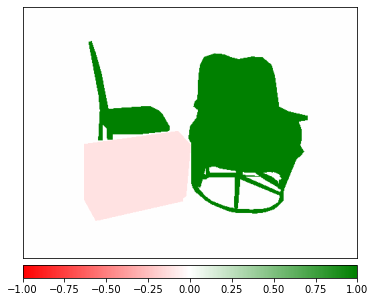

In [16]:
attrs = lasso_lime.attribute(
    img_to_input(img).unsqueeze(0),
    target=765,
    feature_mask=feature_mask,
    n_samples=2 ** n_interpret_features,
    perturbations_per_eval=16,
    show_progress=True,
    return_input_shape=True,
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())
show_attr(attrs)

As shown in the heat map, our ResNet does present right belief about the chair segment. However, it gets hindered by the television segment in the foreground. This may also explain why the model feels less confident about the chairs than the television.

## 2. Text Classification

In this section, we will take use of a news subject classification example to demonstrate more customizable functions in Lime. We will train a simple embedding-bag classifier on AG_NEWS dataset and analyze its understanding of words.

In [17]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from collections import Counter

from IPython.core.display import HTML, display

### 2.1 Load the data and define the model

`torchtext` has included the AG_NEWS dataset but since it is only split into train & test, we need to further cut a validation set from the original train split. Then we build the vocabulary of the frequent words based on our train split.

In [18]:
ag_ds = AG_NEWS(split='train')

ag_train, ag_val = random_split(list(ag_ds), [100000, 20000])

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for (label, line) in ag_train:
    counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=10)

print('Vocabulary size:', len(vocab))

num_class = len(set(label for label, _ in ag_train))
print('Num of classes:', num_class)

Vocabulary size: 18679
Num of classes: 4


The model we use is composed of an embedding-bag, which averages the word embeddings as the latent text representation, and a final linear layers, which maps the latent vector to the logits. Unconventially, `pytorch`'s embedding-bag does not assume the first dimension is the batch. Instead, it requires a flattened vector of indices with an additional offset tensor of batch size. You can refer to its [document](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html#embeddingbag) for details.

In [19]:
class EmbeddingBagModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, num_class)

    def forward(self, inputs, offsets):
        embedded = self.embedding(inputs, offsets)
        return self.linear(embedded)

### 2.2 Training and Baseline Classification

In order to train our classifier, we need to define a collate function to batch the samples into the tensor fomat required by the embedding-bag and create the interable dataloaders.

In [20]:
BATCH_SIZE = 64

def collate_batch(batch):
    labels = torch.tensor([label - 1 for label, _ in batch]) 
    text_list = [tokenizer(line) for _, line in batch]
    
    # flatten tokens across the whole batch
    text = torch.tensor([vocab[t] for tokens in text_list for t in tokens])
    # the offset of each batch
    offsets = torch.tensor(
        [0] + [len(tokens) for tokens in text_list][:-1]
    ).cumsum(dim=0)

    return labels, text, offsets

train_loader = DataLoader(ag_train, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(ag_val, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=collate_batch)

We will then train our embedding-bag model with typical cross-entropy loss and Adam optimizer. Due to the simplicity of this task, 5 epochs should be enough to give us a stable 90% accuracy. 

In [21]:
EPOCHS = 5
EMB_SIZE = 64

def train_model(train_loader, val_loader):
    model = EmbeddingBagModel(len(vocab), EMB_SIZE, num_class)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(1, EPOCHS + 1):      
        # training
        model.train()
        total_acc, total_count = 0, 0
        
        for idx, (label, text, offsets) in enumerate(train_loader):
            optimizer.zero_grad()
            predited_label = model(text, offsets)
            loss(predited_label, label).backward()
            optimizer.step()
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

            if (idx + 1) % 500 == 0:
                print('epoch {:3d} | {:5d}/{:5d} batches '
                      '| accuracy {:8.3f}'.format(epoch, idx + 1, len(train_loader),
                                                  total_acc/total_count))
                total_acc, total_count = 0, 0       
        
        # evaluation
        model.eval()
        total_acc, total_count = 0, 0

        with torch.no_grad():
            for label, text, offsets in val_loader:
                predited_label = model(text, offsets)
                total_acc += (predited_label.argmax(1) == label).sum().item()
                total_count += label.size(0)

        print('-' * 59)
        print('end of epoch {:3d} | '
              'valid accuracy {:8.3f} '.format(epoch, total_acc / total_count))
        print('-' * 59)
        
    return model
        
eb_model = train_model(train_loader, val_loader)

epoch   1 |   500/ 1563 batches | accuracy    0.610
epoch   1 |  1000/ 1563 batches | accuracy    0.836
epoch   1 |  1500/ 1563 batches | accuracy    0.871
-----------------------------------------------------------
end of epoch   1 | valid accuracy    0.887 
-----------------------------------------------------------
epoch   2 |   500/ 1563 batches | accuracy    0.897
epoch   2 |  1000/ 1563 batches | accuracy    0.903
epoch   2 |  1500/ 1563 batches | accuracy    0.908
-----------------------------------------------------------
end of epoch   2 | valid accuracy    0.907 
-----------------------------------------------------------
epoch   3 |   500/ 1563 batches | accuracy    0.919
epoch   3 |  1000/ 1563 batches | accuracy    0.919
epoch   3 |  1500/ 1563 batches | accuracy    0.921
-----------------------------------------------------------
end of epoch   3 | valid accuracy    0.913 
-----------------------------------------------------------
epoch   4 |   500/ 1563 batches | accura

Now, let us pick the following sports news and test how our model performs.

In [23]:
test_label = 2  # {1: World, 2: Sports, 3: Business, 4: Sci/Tec}
test_line = ('US Men Have Right Touch in Relay Duel Against Australia THENS, Aug. 17 '
            '- So Michael Phelps is not going to match the seven gold medals won by Mark Spitz. '
            'And it is too early to tell if he will match Aleksandr Dityatin, '
            'the Soviet gymnast who won eight total medals in 1980.')

test_labels, test_text, test_offsets = collate_batch([(test_label, test_line)])

probs = F.softmax(eb_model(test_text, test_offsets), dim=1).squeeze(0)
print('Prediction probability:', round(probs[test_labels[0]].item(), 4))

Prediction probability: 0.8585


Our embedding-bag does successfully identify the above news as sports with pretty high confidence.

### 2.3 Inspect the model prediction with Lime

Finally, it is time to bring back Lime to inspect how the model makes the prediction. However, we will use the more customizable `LimeBase` class this time which also powers the `Lime` class we used before. The `Lime` class is opinionated when creating features from pertubed binary interpretable representations. It can only set the "absense" features to some baseline values while keeping other "presense" features. This is not what we want in this case. For text, the interpretable representation is a binary vector indicating if the word of each position presents or not. The corresponding text input should literally remove the absent words so our embedding-bag can calculate the average embeddings of the left words. Setting them to baselines cannot give the same result. Therefore, we have to use `LimeBase` to customize the conversion logic through the `from_interp_rep_transform` argument.

`LimeBase` is not opinionated at all so we have to define every piece manually. Let us talk about them in order:
- `forward_func`, the target to attribute. Notice we cannot pass our model directly since Captum always assumes the first dimension is batch while our embedding-bag requires flattened indices. So we will add the dummy dimension later and make a wrapper here to remove the dummy dimension before giving to our model.
- `interpretable_model`, the surrogate model. This works the same as we demonstrated in the above image classification example. We also use sklearn linear lasso here.
- `similarity_func`, the function calculating the weights for training samples. The most common way to calculate the distance of texts is to calculate their cosine similarity in their latent embedding space. The text inputs are just sequences token indices, so we have to leverage the trained embedding layer from the model to encode them to retrieve their latent vectors. Due to this extra encoding step, we cannot directly use the `get_exp_kernel_similarity_function('cosine')` like in the image classification example, which directly calculate the cosine similarity of the given inputs.
- `perturb_func`, the function to sample interpretable representations. We present another way to define this argument other than using generator as shown the above image classification. Here we directly define a function returning a randomized sample every call. It outputs a binary vector where each token is selected independently and uniformly at random.
- `perturb_interpretable_space`, whether perturbed samples are in interpretable space. `LimeBase` also supports sampling in the original input space, but we do not need it in our case.
- `from_interp_rep_transform`, the function transforming the perturbed interpretable samples back to the original input space. As explained above, this argument is the main reason for us to use `LimeBase`. We pick a subset of the present tokens from the original text input according to the interpretable representation.
- `to_interp_rep_transform`, the opposite of `from_interp_rep_transform`. It is needed only when `perturb_interpretable_space` is set to false.

In [24]:
# remove the batch dimension for the embedding-bag model
def forward_func(text, offsets):
    return eb_model(text.squeeze(0), offsets)

# encode text indices into latent representations & calculate cosine similarity
def exp_embedding_cosine_distance(original_inp, perturbed_inp, _, **kwargs):
    original_emb = eb_model.embedding(original_inp, None)
    perturbed_emb = eb_model.embedding(perturbed_inp, None)
    distance = 1 - F.cosine_similarity(original_emb, perturbed_emb, dim=1)
    return torch.exp(-1 * (distance ** 2) / 2)

# binary vector where each word is selected independently and uniformly at random
def bernoulli_perturb(text, **kwargs):
    probs = torch.ones_like(text) * 0.5
    return torch.bernoulli(probs).long()

# remove absenst token based on the intepretable representation sample
def interp_to_input(interp_sample, original_input, **kwargs):
    return original_input[interp_sample.bool()].view(original_input.size(0), -1)

lasso_lime_base = LimeBase(
    forward_func, 
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_embedding_cosine_distance,
    perturb_func=bernoulli_perturb,
    perturb_interpretable_space=True,
    from_interp_rep_transform=interp_to_input,
    to_interp_rep_transform=None
)

The attribution call is the same as the `Lime` class. Just remember to add the dummy batch dimension to the text input and put the offsets in the `additional_forward_args` because it is not a feature for the classification but a metadata for the text input.

In [25]:
attrs = lasso_lime_base.attribute(
    test_text.unsqueeze(0), # add batch dimension for Captum
    target=test_labels,
    additional_forward_args=(test_offsets,),
    n_samples=5000,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime Base attribution: 100%|██████████| 5000/5000 [00:02<00:00, 1799.08it/s]


Attribution range: -0.36165791749954224 to 0.777672290802002


At last, let us create a simple visualization to highlight the influential words where green stands for positive correlation and red for negative.

In [26]:
def display_text_attr(attrs):
    color = lambda x: '255,0' if x < 0 else '0,255'
    token_marks = [
        f'<mark style="background-color:rgba({color(attr)},0,{abs(attr) ** 0.5})">{token}</mark>'
        for token, attr in zip(tokenizer(test_line), attrs.tolist())
    ]
    
    html = HTML('<p>' + ' '.join(token_marks) + '</p>')
    display(html)
    
display_text_attr(attrs)

As shown above, the model links the "Sports" subject to many reasonable words, like "match" and "medals".